## <font color='darkblue'>Preface</font>
([article source](https://www.tensorflow.org/tutorials/keras/regression)) <font size='3ptx'><b>In a [regression problem](https://en.wikipedia.org/wiki/Regression_analysis), the aim is to predict the output of a continuous value, like a price or a probability</b>. Contrast this with a classification problem, where the aim is to select a class from a list of classes (<font color='brown'>for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture</font>).</font>

This tutorial uses the classic [**Auto MPG dataset**](https://archive.ics.uci.edu/ml/datasets/auto+mpg) and demonstrates how to build models to predict the fuel efficiency of the late-1970s and early 1980s automobiles. To do this, you will provide the models with a description of many automobiles from that time period. This description includes attributes like cylinders, displacement, horsepower, and weight.

This example uses the Keras API. (Visit the Keras [tutorials](https://www.tensorflow.org/tutorials/keras) and [guides](https://www.tensorflow.org/guide/keras) to learn more.)

In [28]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
np.seterr(all="ignore")

tf.get_logger().setLevel(logging.ERROR)

print(tf.__version__)

2.9.1


In [14]:
RANDOM_STATE = 42

<a id='sect0'></a>
### <font color='darkgreen'>Agenda</font>
* <font size='3ptx'><b><a href='#sect1'>The Auto MPG dataset</a></b></font>

<a id='sect1'></a>
## <font color='darkblue'>The Auto MPG dataset</font>
<font size='3ptx'><b>The dataset is available from the UCI Machine Learning Repository.</b></font>

### <font color='darkgreen'>Get the data</font>

First download and import the dataset using pandas:

In [4]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [8]:
print(raw_dataset.shape)
raw_dataset.sample(n=3)

(398, 8)


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
5,15.0,8,429.0,198.0,4341.0,10.0,70,1
120,19.0,4,121.0,112.0,2868.0,15.5,73,2
59,23.0,4,97.0,54.0,2254.0,23.5,72,2


### <font color='darkgreen'>Clean the data</font>
The dataset contains a few unknown values:

In [7]:
raw_dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

Drop those rows to keep this initial tutorial simple:

In [9]:
dataset = raw_dataset.dropna()

The `Origin` column is categorical, not numeric. So the next step is to one-hot encode the values in the column with [pd.get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html).

<b><font color='darkred'>Note</font></b>: You can set up the [**tf.keras.Model**](https://www.tensorflow.org/api_docs/python/tf/keras/Model) to do this kind of transformation for you but that's beyond the scope of this tutorial. Check out the [Classify structured data using Keras preprocessing layers](https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers) or [Load CSV data tutorials](https://www.tensorflow.org/tutorials/load_data/csv) for examples.

In [10]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')

/tmp/ipykernel_202223/165929530.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})


In [11]:
dataset.sample(n=3)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
115,15.0,8,350.0,145.0,4082.0,13.0,73,0,0,1
338,27.2,4,135.0,84.0,2490.0,15.7,81,0,0,1
83,28.0,4,98.0,80.0,2164.0,15.0,72,0,0,1


### <font color='darkgreen'>Split the data into training and test sets</font>
Now, split the dataset into a training set and a test set. You will use the test set in the final evaluation of your models.

In [15]:
train_dataset = dataset.sample(frac=0.8, random_state=RANDOM_STATE)
test_dataset = dataset.drop(train_dataset.index)

### <font color='darkgreen'>Inspect the data</font>
Review the joint distribution of a few pairs of columns from the training set.

The top row suggests that the fuel efficiency (MPG) is a function of all the other parameters. The other rows indicate they are functions of each other.

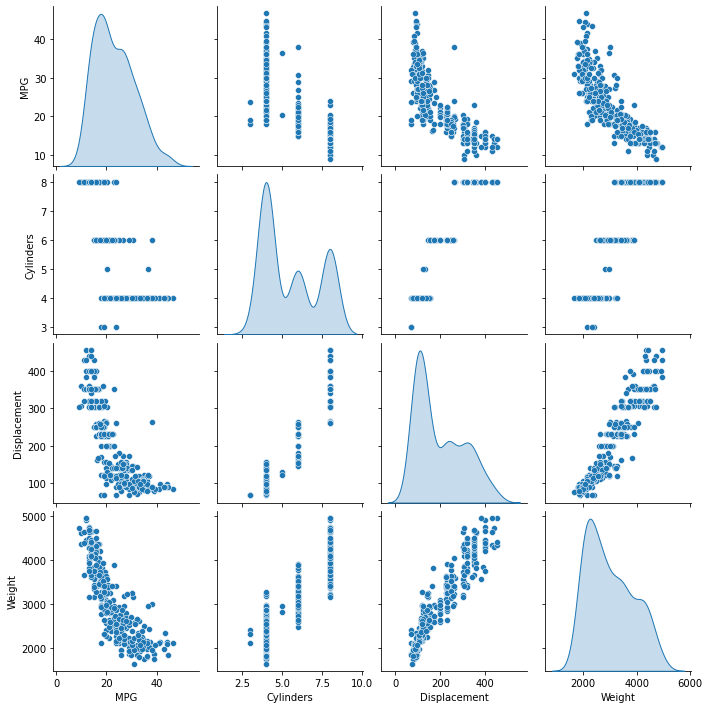

In [22]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')
#plt.rcParams['figure.figsize'] = [6, 6]
plt.show()

Let's also check the overall statistics. Note how each feature covers a very different range:

In [23]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.153822,7.861854,9.0,17.000,22.0,28.075,46.6
Cylinders,314.0,5.531847,1.729449,3.0,4.000,4.0,8.000,8.0
Displacement,314.0,197.855096,106.501896,68.0,105.000,151.0,302.000,455.0
Horsepower,314.0,105.971338,39.636557,46.0,76.000,95.0,130.000,230.0
Weight,314.0,3005.745223,859.060925,1649.0,2231.000,2831.5,3641.750,4955.0
Acceleration,314.0,15.510828,2.803560,8.0,13.625,15.5,17.000,24.8
Model Year,314.0,75.910828,3.688989,70.0,73.000,76.0,79.000,82.0
Europe,314.0,0.171975,0.377961,0.0,0.000,0.0,0.000,1.0
Japan,314.0,0.203822,0.403481,0.0,0.000,0.0,0.000,1.0
USA,314.0,0.624204,0.485101,0.0,0.000,1.0,1.000,1.0


### <font color='darkgreen'>Split features from labels</font>
Separate the target value—the `MPG`—from the features. This label is the value that you will train the model to predict.

In [24]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

## <font color='darkblue'>Normalization</font>
In the table of statistics it's easy to see how different the ranges of each feature are:

In [25]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.153822,7.861854
Cylinders,5.531847,1.729449
Displacement,197.855096,106.501896
Horsepower,105.971338,39.636557
Weight,3005.745223,859.060925
Acceleration,15.510828,2.803560
Model Year,75.910828,3.688989
Europe,0.171975,0.377961
Japan,0.203822,0.403481
USA,0.624204,0.485101


<b><font color='darkgreen'>It is good practice to normalize features that use different scales and ranges.</font></b> 

One reason this is important is because the features are multiplied by the model weights. So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

<b>Although a model might converge without feature normalization, normalization makes training much more stable.</b>

### <font color='darkgreen'>The Normalization layer</font>
The [**tf.keras.layers.Normalization**](https://keras.io/api/layers/preprocessing_layers/core_preprocessing_layers/normalization/) is a clean and simple way to add feature normalization into your model.

The first step is to create the layer:

In [26]:
normalizer = tf.keras.layers.Normalization(axis=-1)

Then, fit the state of the preprocessing layer to the data by calling <font color='blue'><b>Normalization</b>.adapt</font>:

In [29]:
normalizer.adapt(np.array(train_features))

Calculate the mean and variance, and store them in the layer:

In [30]:
print(normalizer.mean.numpy())

[[   5.532  197.855  105.971 3005.746   15.511   75.911    0.172    0.204
     0.624]]


When the layer is called, it returns the input data, with each feature independently normalized:

In [31]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())

First example: [[   4.   96.   69. 2189.   18.   72.    1.    0.    0.]]

Normalized: [[-0.89 -0.96 -0.93 -0.95  0.89 -1.06  2.19 -0.51 -1.29]]


## <font color='darkblue'>Linear regression</font>
Before building a deep neural network model, start with linear regression using one and several variables.

### <font color='darkgreen'>Linear regression with one variable</font>
<font size='3ptx'><b>Begin with a single-variable linear regression to predict `MPG` from `Horsepower`.</b></font>

Training a model with [**tf.keras**](https://www.tensorflow.org/api_docs/python/tf/keras) typically starts by defining the model architecture. Use a [**tf.keras.Sequential**](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) model, which [represents a sequence of steps](https://www.tensorflow.org/guide/keras/sequential_model). There are two steps in your single-variable linear regression model:
* Normalize the `Horsepower` input features using the [**tf.keras.layers.Normalization**](https://keras.io/api/layers/preprocessing_layers/core_preprocessing_layers/normalization/) preprocessing layer.
* Apply a linear transformation($y=m.x + b$) to produce 1 output using a linear layer ([**tf.keras.layers.Dense**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)).

<br/>

The number of inputs can either be set by the <font color='violet'>input_shape</font> argument, or automatically when the model is run for the first time.

First, create a NumPy array made of the `Horsepower` features. Then, instantiate the [**tf.keras.layers.Normalization**](https://keras.io/api/layers/preprocessing_layers/core_preprocessing_layers/normalization/) and fit its state to the horsepower data:

In [32]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

Build the Keras Sequential model:

In [33]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


<b>This model will predict `MPG` from `Horsepower`.</b> Run the untrained model on the first 10 'Horsepower' values. The output won't be good, but notice that it has the expected shape of (10, 1):

In [34]:
horsepower_model.predict(horsepower[:10])

1/1 [==============================] - 0s 110ms/step


array([[-0.953],
       [ 0.233],
       [-1.185],
       [-0.927],
       [-0.515],
       [-0.799],
       [ 1.651],
       [-0.799],
       [-0.283],
       [-1.469]], dtype=float32)

Once the model is built, configure the training procedure using the Keras [**Model.compile**](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) method. The most important arguments to compile are the <font color='violet'>loss</font> and the <font color='violet'>optimizer</font>, since these define what will be optimized (`mean_absolute_error`) and how (<font color='brown'>using the [**tf.keras.optimizers.Adam**](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)</font>).

In [35]:
horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Use Keras [**Model.fit**](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) to execute the training for 100 epochs:

In [36]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 3.99 s, sys: 1.17 s, total: 5.16 s
Wall time: 4.34 s


Visualize the model's training progress using the stats stored in the `history` object:

In [37]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.909052,3.333055,95
96,3.905491,3.320881,96
97,3.906036,3.311195,97
98,3.905326,3.319341,98
99,3.906148,3.324729,99
